In [20]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [22]:
messages = pd.read_csv('/content/mail_data.csv')


In [23]:
df = pd.DataFrame(messages)

In [24]:

print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
display(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

First few rows:


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [32]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Enhanced text preprocessing"""
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove phone numbers
        text = re.sub(r'\b\d{10}\b|\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)

        # Remove special characters but keep meaningful punctuation
        text = re.sub(r'[^a-zA-Z\s!?.]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        # Tokenization
        tokens = word_tokenize(text)

        # Lemmatization and stopword removal
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

In [26]:
preprocessor = TextPreprocessor()

# Preprocess messages
df['cleaned_text'] = df['Message'].apply(preprocessor.preprocess_text)

# Convert categories to binary
df['is_spam'] = (df['Category'] == 'spam').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['is_spam'],
    test_size=0.2,
    random_state=42,
    stratify=df['is_spam']
)


In [31]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 3),
        stop_words='english',
        min_df=2,
        max_df=0.95
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    ))
])


param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("Training model...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")



y_pred = grid_search.predict(X_test)


Training model...

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 3)}
Best cross-validation score: 0.914



Model Performance Metrics:
accuracy: 0.977
precision: 0.942
recall: 0.879
f1_score: 0.910


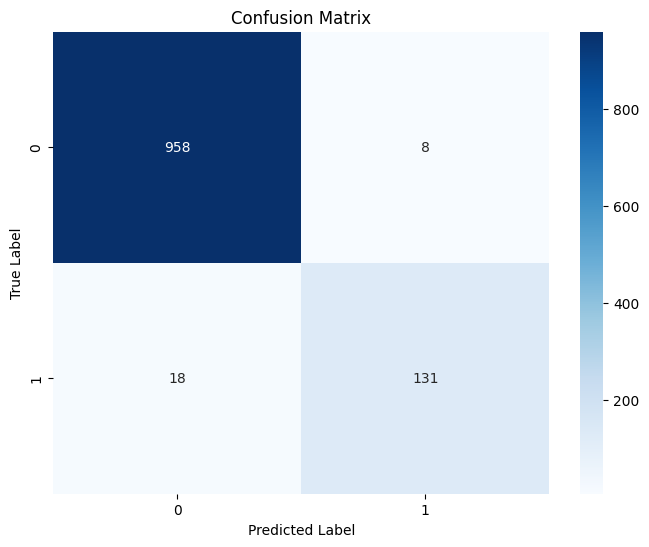

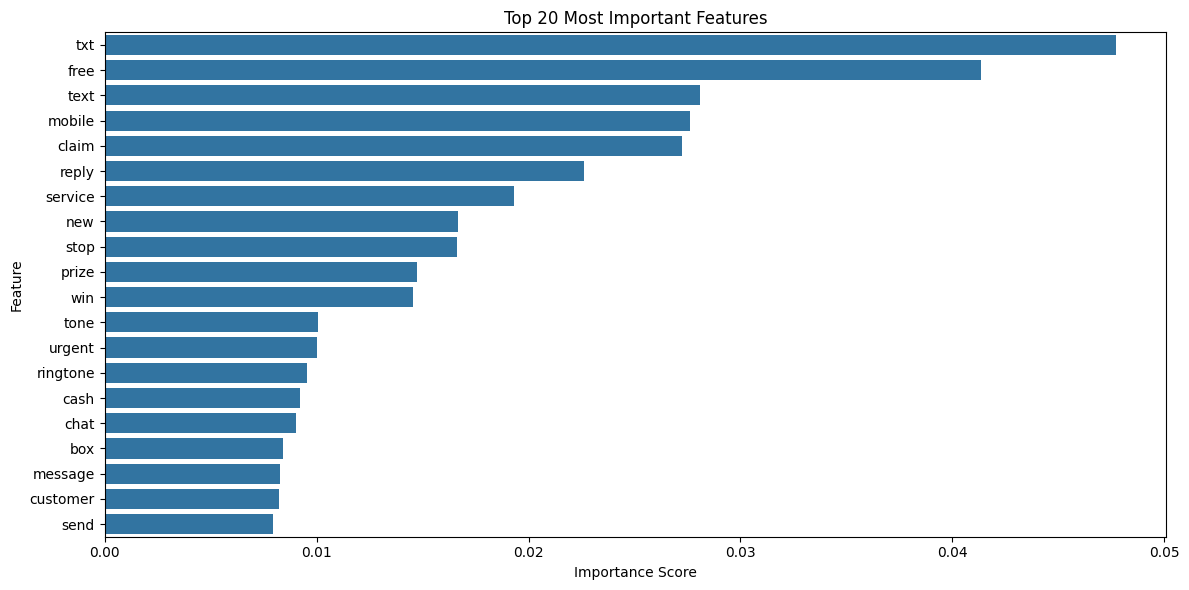

In [28]:
results = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred)
}

print("\nModel Performance Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cell 7 - Feature Importance Analysis
# Get feature names and importance scores
tfidf = grid_search.best_estimator_.named_steps['tfidf']
classifier = grid_search.best_estimator_.named_steps['classifier']

feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': classifier.feature_importances_
})

# Sort and plot top features
top_features = feature_importance.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [29]:
def predict_message(message):
    """Predict whether a new message is spam or not"""
    # Preprocess the message
    cleaned_message = preprocessor.preprocess_text(message)

    # Make prediction
    prediction = grid_search.predict([cleaned_message])[0]
    probability = grid_search.predict_proba([cleaned_message])[0]

    return prediction, probability

# Test with example messages
test_messages = [
    "URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot!",
    "Hey, what time is the meeting tomorrow?",
    "Hey, are you free to catch up later tonight?"
]

print("Testing new messages:")
for msg in test_messages:
    pred, prob = predict_message(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {'Spam' if pred else 'Ham'}")
    print(f"Confidence: {max(prob):.2f}")

Testing new messages:

Message: URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot!
Prediction: Spam
Confidence: 0.66

Message: Hey, what time is the meeting tomorrow?
Prediction: Ham
Confidence: 1.00

Message: Hey, are you free to catch up later tonight?
Prediction: Ham
Confidence: 0.83
